# Using Fortran and C code with Python

this is another notebook from J.R. Johansson

here is a link to [another F2Py tutorial](https://github.com/thehackerwithin/PyTrieste/wiki/F2Py)

In [1]:
%pylab inline
from IPython.display import Image

#if you are not on byrd: sudo yum install f2py

Populating the interactive namespace from numpy and matplotlib


The advantage of Python is that it is flexible and easy to program. The time it takes to setup a new calulation is therefore short. But for certain types of calculations Python (and any other interpreted language) can be very slow. It is particularly iterations over large arrays that is difficult to do efficiently.

Such calculations may be implemented in a compiled language such as C or Fortran. In Python it is relatively easy to call out to libraries with compiled C or Fortran code. In this lecture we will look at how to do that.

But before we go ahead and work on optimizing anything, it is always worthwhile to ask.... 

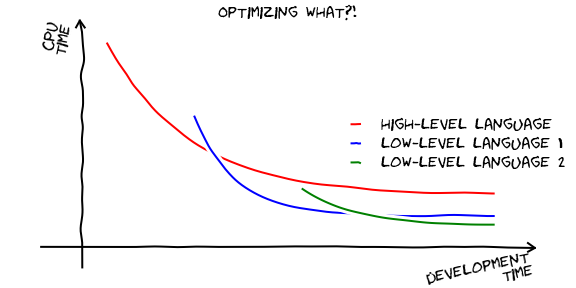

In [2]:
Image(filename='images/optimizing-what.png')

## Fortran

### F2Py

F2PY is a program that (almost) automatically wraps fortran code for use in Python: By using the `f2py` program we can compile fortran code into a module that we can import in a Python program.

F2PY is a part of NumPy, but you will also need to have a fortran compiler to run the examples below.

### Example 0: scalar input, no output

In [3]:
%%file hellofortran.f
C File  hellofortran.f
        subroutine hellofortran (n)
        integer n
       
        do 100 i=1, n
            print *,i, "Fortran says hello"
100     continue
        end

Overwriting hellofortran.f


Generate a python module using `f2py`:

In [4]:
!source deactivate pangeo; f2py -c -m hellofortran hellofortran.f

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "hellofortran" sources
f2py options: []
f2py:> /tmp/tmp32w1xbxr/src.linux-x86_64-3.6/hellofortranmodule.c
creating /tmp/tmp32w1xbxr/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'hellofortran.f' (format:fix,strict)
Post-processing...
	Block: hellofortran
			Block: hellofortran
Post-processing (stage 2)...
Building modules...
	Building module "hellofortran"...
		Constructing wrapper function "hellofortran"...
		  hellofortran(n)
	Wrote C/API module "hellofortran" to file "/tmp/tmp32w1xbxr/src.linux-x86_64-3.6/hellofortranmodule.c"
  adding '/tmp/tmp32w1xbxr/src.linux-x86_64-3.6/fortranobject.c' to sources.
  adding '/tmp/tmp32w1xbxr/src.linux-x86_64-3.6' to include_dirs.
copying /home2/nhn2/miniconda3/envs/pange

Example of a python script that use the module:

In [5]:
%%file hello.py
import hellofortran

hellofortran.hellofortran(4)

Overwriting hello.py


In [6]:
# run the script
!python hello.py

           1 Fortran says hello
           2 Fortran says hello
           3 Fortran says hello
           4 Fortran says hello


### Example 1: vector input and scalar output

In [7]:
%%file dprod.f

       subroutine dprod(x, y, n)
       integer n
       double precision x(n), y
       y = 1.0
    
       do 100 i= 1, n
           y = y * x(i)
100    continue
       end

Overwriting dprod.f


In [8]:
!rm -f dprod.pyf
!f2py -m dprod -h dprod.pyf dprod.f

Reading fortran codes...
	Reading file 'dprod.f' (format:fix,strict)
Post-processing...
	Block: dprod
			Block: dprod
Post-processing (stage 2)...
Saving signatures to file "./dprod.pyf"


The `f2py` program generated a module declaration file called `dprod.pyf`. Let's look what's in it:

In [9]:
!cat dprod.pyf

!    -*- f90 -*-
! Note: the context of this file is case sensitive.

python module dprod ! in 
    interface  ! in :dprod
        subroutine dprod(x,y,n) ! in :dprod:dprod.f
            double precision dimension(n) :: x
            double precision :: y
            integer, optional,check(len(x)>=n),depend(x) :: n=len(x)
        end subroutine dprod
    end interface 
end python module dprod

! This file was auto-generated with f2py (version:2).
! See http://cens.ioc.ee/projects/f2py2e/


The module does not know what Fortran subroutine arguments are input and output, so we need to manually edit the module declaration files and mark output variables with `intent(out)` and input variable with `intent(in)`:

In [10]:
%%file dprod.pyf
python module dprod ! in 
    interface  ! in :dprod
        subroutine dprod(x,y,n) ! in :dprod:dprod.f
            double precision dimension(n), intent(in) :: x
            double precision, intent(out) :: y
            integer, optional,check(len(x)>=n),depend(x),intent(in) :: n=len(x)
        end subroutine dprod
    end interface 
end python module dprod

Overwriting dprod.pyf


Compile the fortran code into a module that can be included in python:

In [11]:
!source deactivate pangeo; f2py -c dprod.pyf dprod.f; source activate pangeo

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "dprod" sources
creating /tmp/tmpsds5fq9n/src.linux-x86_64-3.6
f2py options: []
f2py: dprod.pyf
Reading fortran codes...
	Reading file 'dprod.pyf' (format:free)
Post-processing...
	Block: dprod
			Block: dprod
Post-processing (stage 2)...
Building modules...
	Building module "dprod"...
		Constructing wrapper function "dprod"...
		  y = dprod(x,[n])
	Wrote C/API module "dprod" to file "/tmp/tmpsds5fq9n/src.linux-x86_64-3.6/dprodmodule.c"
  adding '/tmp/tmpsds5fq9n/src.linux-x86_64-3.6/fortranobject.c' to sources.
  adding '/tmp/tmpsds5fq9n/src.linux-x86_64-3.6' to include_dirs.
copying /home2/nhn2/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/f2py/src/fortranobject.c -> /tmp/tmpsds5fq9n/src.linux-x86_64-3.6
copying

#### Using the module from Python

In [13]:
import dprod

In [14]:
help(dprod)

Help on module dprod:

NAME
    dprod

DESCRIPTION
    This module 'dprod' is auto-generated with f2py (version:2).
    Functions:
      y = dprod(x,n=len(x))
    .

DATA
    dprod = <fortran object>

VERSION
    b'$Revision: $'

FILE
    /home/home2/nhn2/notebooks/dprod.cpython-36m-x86_64-linux-gnu.so




In [15]:
dprod.dprod(arange(1.0,50.0))

6.082818640342675e+62

In [16]:
# compare to numpy
prod(arange(1.0,50.0))

6.082818640342675e+62

In [17]:
dprod.dprod(arange(1,10), 5) # only the 5 first elements

120.0

Compare performance:

In [18]:
xvec = rand(500)

In [19]:
timeit dprod.dprod(xvec)

933 ns ± 22.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
timeit xvec.prod()

2.16 µs ± 7.07 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Example 2: cummulative sum, vector input and vector output

The cummulative sum function for an array of data is a good example of a loop intense algorithm: Loop through a vector and store the cummulative sum in another vector.

In [21]:
# simple python algorithm: example of a SLOW implementation
# Why? Because the loop is implemented in python.
def py_dcumsum(a):
    b = empty_like(a)
    b[0] = a[0]
    for n in range(1,len(a)):
        b[n] = b[n-1]+a[n]
    return b

Fortran subroutine for the same thing: here we have added the `intent(in)` and `intent(out)` as comment lines in the original fortran code, so we do not need to manually edit the fortran module declaration file generated by `f2py`. 

In [22]:
%%file dcumsum.f
c File dcumsum.f
       subroutine dcumsum(a, b, n)
       double precision a(n)
       double precision b(n)
       integer n
cf2py  intent(in) :: a
cf2py  intent(out) :: b
cf2py  intent(hide) :: n

       b(1) = a(1)
       do 100 i=2, n
           b(i) = b(i-1) + a(i)
100    continue
       end

Overwriting dcumsum.f


We can directly compile the fortran code to a python module:

In [23]:
!source deactivate pangeo; f2py -c dcumsum.f -m dcumsum; source activate pangeo

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "dcumsum" sources
f2py options: []
f2py:> /tmp/tmpsj8xct9a/src.linux-x86_64-3.6/dcumsummodule.c
creating /tmp/tmpsj8xct9a/src.linux-x86_64-3.6
Reading fortran codes...
	Reading file 'dcumsum.f' (format:fix,strict)
Post-processing...
	Block: dcumsum
			Block: dcumsum
Post-processing (stage 2)...
Building modules...
	Building module "dcumsum"...
		Constructing wrapper function "dcumsum"...
		  b = dcumsum(a)
	Wrote C/API module "dcumsum" to file "/tmp/tmpsj8xct9a/src.linux-x86_64-3.6/dcumsummodule.c"
  adding '/tmp/tmpsj8xct9a/src.linux-x86_64-3.6/fortranobject.c' to sources.
  adding '/tmp/tmpsj8xct9a/src.linux-x86_64-3.6' to include_dirs.
copying /home2/nhn2/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/f2py/src/f

In [24]:
import dcumsum

In [25]:
a = array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])

In [26]:
py_dcumsum(a)

array([ 1.,  3.,  6., 10., 15., 21., 28., 36.])

In [27]:
dcumsum.dcumsum(a)

array([ 1.,  3.,  6., 10., 15., 21., 28., 36.])

In [28]:
cumsum(a)

array([ 1.,  3.,  6., 10., 15., 21., 28., 36.])

Benchmark the different implementations:

In [29]:
a = rand(10000)

In [30]:
timeit py_dcumsum(a)

2.77 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
timeit dcumsum.dcumsum(a)

11.6 µs ± 425 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
timeit a.cumsum()

28.6 µs ± 437 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## C

## ctypes

ctypes is a Python library for calling out to C code. It is not as automatic as `f2py`, and we manually need to load the library and set properties such as the functions return and argument types. On the otherhand we do not need to touch the C code at all. 

In [ ]:
%%file functions.c

#include <stdio.h>

void hello(int n);

double dprod(double *x, int n);

void dcumsum(double *a, double *b, int n);

void
hello(int n)
{
    int i;
    
    for (i = 0; i < n; i++)
    {
        printf("C says hello\n");
    }
}


double 
dprod(double *x, int n)
{
    int i;
    double y = 1.0;
    
    for (i = 0; i < n; i++)
    {
        y *= x[i];
    }

    return y;
}

void
dcumsum(double *a, double *b, int n)
{
    int i;
    
    b[0] = a[0];
    for (i = 1; i < n; i++)
    {
        b[i] = a[i] + b[i-1];
    }
}

Compile the C file into a shared library:

In [ ]:
!gcc -c -Wall -O2 -Wall -ansi -pedantic -fPIC -o functions.o functions.c
!gcc -o libfunctions.so -shared functions.o

The result is a compiled shared library `libfunctions.so`:

In [ ]:
!file libfunctions.so

Now we need to write wrapper functions to access the C library: To load the library we use the ctypes package, which included in the Python standard library (with extensions from numpy for passing arrays to C). Then we manually set the types of the argument and return values (no automatic code inspection here!). 

In [ ]:
%%file functions.py

import numpy
import ctypes

_libfunctions = numpy.ctypeslib.load_library('libfunctions', '.')

_libfunctions.hello.argtypes = [ctypes.c_int]
_libfunctions.hello.restype  =  ctypes.c_void_p

_libfunctions.dprod.argtypes = [numpy.ctypeslib.ndpointer(dtype=numpy.float), ctypes.c_int]
_libfunctions.dprod.restype  = ctypes.c_double

_libfunctions.dcumsum.argtypes = [numpy.ctypeslib.ndpointer(dtype=numpy.float), numpy.ctypeslib.ndpointer(dtype=numpy.float), ctypes.c_int]
_libfunctions.dcumsum.restype  = ctypes.c_void_p

def hello(n):
    return _libfunctions.hello(int(n))

def dprod(x, n=None):
    if n is None:
        n = len(x)
    x = numpy.asarray(x, dtype=numpy.float)
    return _libfunctions.dprod(x, int(n))

def dcumsum(a, n):
    a = numpy.asarray(a, dtype=numpy.float)
    b = numpy.empty(len(a), dtype=numpy.float)
    _libfunctions.dcumsum(a, b, int(n))
    return b

In [ ]:
%%file run_hello_c.py

import functions

functions.hello(3)

In [ ]:
!python run_hello_c.py

In [ ]:
import functions

### Product function:

In [ ]:
functions.dprod([1,2,3,4,5]) 

### Cumulative sum:

In [ ]:
a = rand(100000)
b = np.asarray(a)

In [ ]:
import xarray as xr
da = xr.DataArray(a, dims=['x'])
da

In [ ]:
res_c = functions.dcumsum(a, len(a)) 

In [ ]:
res_fortran = dcumsum.dcumsum(a)

In [ ]:
res_c - res_fortran

### Simple benchmarking

In [ ]:
timeit dcumsum.dcumsum(a)

In [ ]:
timeit functions.dcumsum(a, len(a))

In [ ]:
timeit a.cumsum()

In [ ]:
timeit b.cumsum()

In [ ]:
timeit da.cumsum('x')

### Further reading

* http://docs.python.org/2/library/ctypes.html
* http://www.scipy.org/Cookbook/Ctypes

## Cython

A hybrid between python and C that can be compiled: Basically Python code with type declarations.

In [ ]:
%%file cy_dcumsum.pyx
# ln -s ~/miniconda3/lib/python3.6/site-packages/numpy/core/include/numpy ~/miniconda3/envs/pangeo/include/python3.6m/
cimport numpy

def dcumsum(numpy.ndarray[numpy.float64_t, ndim=1] a, numpy.ndarray[numpy.float64_t, ndim=1] b):
    cdef int i, n = len(a)
    b[0] = a[0]
    for i from 1 <= i < n:
        b[i] = b[i-1] + a[i]
    return b

A build file for generating C code and compiling it into a Python module.

In [ ]:
%%file setup.py

from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext

setup(
    cmdclass = {'build_ext': build_ext},
    ext_modules = [Extension("cy_dcumsum", ["cy_dcumsum.pyx"])]
)

In [ ]:
!python setup.py build_ext --inplace

In [ ]:
import cy_dcumsum

In [ ]:
a = array([1,2,3,4], dtype=float)
b = empty_like(a)
cy_dcumsum.dcumsum(a,b)
b

In [ ]:
a = array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

In [ ]:
b = empty_like(a)
cy_dcumsum.dcumsum(a, b)
b

In [ ]:
py_dcumsum(a)

In [ ]:
a = rand(100000)
b = empty_like(a)

In [ ]:
timeit py_dcumsum(a)

In [ ]:
timeit cy_dcumsum.dcumsum(a,b)

### Cython in the IPython notebook

When working with the IPython (especially in the notebook), there is a more convenient way of compiling and loading Cython code. Using the `%%cython` IPython magic (command to IPython), we can simply type the Cython code in a code cell and let IPython take care of the conversion to C code, compilation and loading of the function. To be able to use the `%%cython` magic, we first need to load the extension `Cython`:

In [ ]:
%load_ext Cython

In [ ]:
%%cython

cimport numpy

def cy_dcumsum2(numpy.ndarray[numpy.float64_t, ndim=1] a, numpy.ndarray[numpy.float64_t, ndim=1] b):
    cdef int i, n = len(a)
    b[0] = a[0]
    for i from 1 <= i < n:
        b[i] = b[i-1] + a[i]
    return b

In [ ]:
timeit cy_dcumsum2(a,b)

### Further reading

* http://cython.org